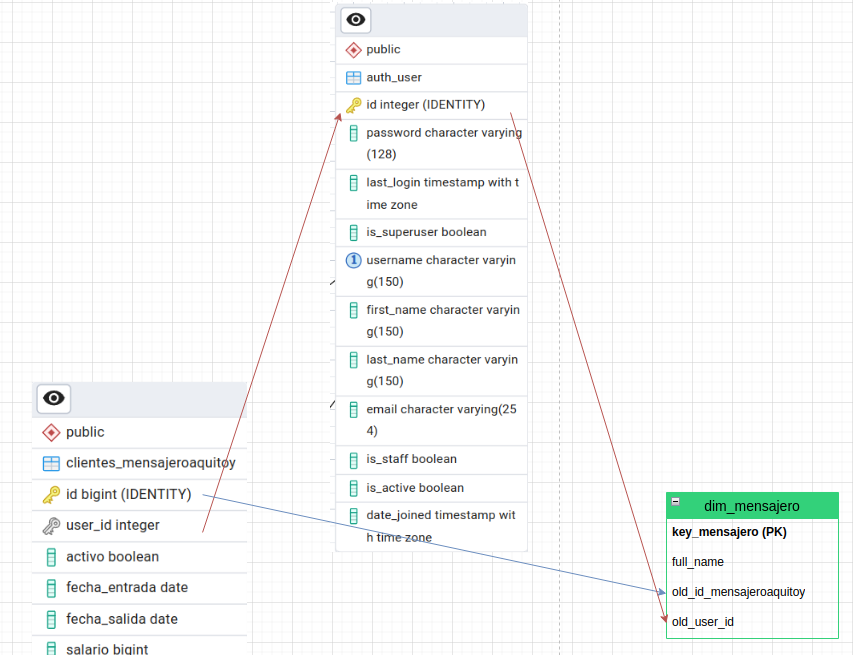

## Importar librerías

In [ ]:
# Importar las librerias
from datetime import datetime  # Para obtener el tiempo actual
import pandas as pd  # Para manipular datos
import sqlalchemy as sa  # Para conectar a la base de datos
import utils.conn_tools as ct  # Para leer la configuración de conexión
import numpy as np  # Para tener el Nan de Python

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

## Extract

In [ ]:
# Leer los datos de las tablas
mensajeros = pd.read_sql_table('clientes_mensajeroaquitoy', con=engine_src)
auth_user_df = pd.read_sql_table('auth_user', con=engine_src)

In [ ]:
# Comprobar los campos
mensajeros.rename(columns={"id": "old_id_mensajeroaquitoy"}, inplace=True)
mensajeros.info()

In [ ]:
# Comprobar los campos
auth_user_df.info()

## Transform: Ajustes de la dimensión

### Obtener datos de usuarios que son mensajeros

In [ ]:
merged_df = mensajeros.merge(
  auth_user_df,
  left_on="user_id",
  right_on="id",
  how="left",
  suffixes=("_clientes", "_authusers"),
)

# Imprimir los resultados
print(f"Número de user_id distintos: {merged_df["user_id"].nunique()}")
print(
    f"Número de old_id_mensajeroaquitoy distintos: {merged_df["old_id_mensajeroaquitoy"].nunique()}"
)
print(f"Número total de registros: {merged_df.shape[0]}")

merged_df.head(5)

### Extraer solo los campos relevantes

In [ ]:
dim_mensajero = pd.DataFrame(
    {
        "full_name": merged_df["username"].values,
        "old_id_mensajeroaquitoy": merged_df["old_id_mensajeroaquitoy"].values,
        "old_user_id": merged_df["user_id"].values,
    }
)

dim_mensajero.head(5)

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

dim_mensajero_table = sa.Table(
    "dim_mensajero",
    metadata,
    # Primary key
    sa.Column("key_mensajero", sa.Integer, primary_key=True, autoincrement=True),
    # Dimension keys
    sa.Column("full_name", sa.String, nullable=False),
    sa.Column("old_id_mensajeroaquitoy", sa.Integer, nullable=False),
    sa.Column("old_user_id", sa.Integer, nullable=False),
)

metadata.create_all(engine_etl)

## Load: Ejecución de ETL

In [ ]:
dim_mensajero.to_sql(
    name="dim_mensajero",
    con=engine_etl,
    if_exists="append",  # Create table if not exists, else append    
    index=False,  # Do not create index because we already have one PK
)